<a href="https://colab.research.google.com/github/ormorteey/BST-222-Survival-Analysis/blob/main/BST_222_HW_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages("pacman")
library("pacman")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
p_load("tidyverse", "googledrive", "KMsurv", "survival", "survminer", "ggplot2")

In [3]:
rm(list = ls())

In [4]:
drive_deauth()
drive_user()
public_file = drive_get(as_id("1CXILLG1-6nRpczvQNnAWEpNdxKc0ed-2"))
drive_download(public_file, overwrite = TRUE)

ℹ Not logged in as any specific Google user.

File downloaded:

• addicts.txt <id: 1CXILLG1-6nRpczvQNnAWEpNdxKc0ed-2>

Saved locally as:

• addicts.txt



In [5]:
vars <- c("id","clinic","status","time","prison","methadone")
addicts <- read.table("addicts.txt",header=F,col.names=vars)

In [6]:
addicts$clinic = factor(addicts$clinic, labels = c("1", " 2"))
addicts$prison = factor(addicts$prison, labels = c("No", "Yes"))
# addicts$status = factor(addicts$status, labels = c("0", "1"))
head(addicts)


,id,clinic,status,time,prison,methadone
,<int>,<fct>,<int>,<int>,<fct>,<int>
1,1,1,1,428,No,50
2,2,1,1,275,Yes,55
3,3,1,1,262,No,55
4,4,1,1,183,No,30
5,5,1,1,259,Yes,65
6,6,1,1,714,No,55


## **Q 1**

Test proportionality of hazards with cox.zph on the model with clinic, prison, and methadone. Make the three plots vs. time of the Schoenfeld residuals for clinic, prison, and methadone. Interpret the results

In [7]:
survival = Surv(time = addicts$time, event = addicts$status)
cox_model_1 <- coxph(survival~ clinic + prison + methadone, data = addicts)
print(summary(cox_model_1))

Call:
coxph(formula = survival ~ clinic + prison + methadone, data = addicts)

  n= 238, number of events= 150 

               coef exp(coef)  se(coef)      z Pr(>|z|)    
clinic 2  -1.009896  0.364257  0.214889 -4.700 2.61e-06 ***
prisonYes  0.326555  1.386184  0.167225  1.953   0.0508 .  
methadone -0.035369  0.965249  0.006379 -5.545 2.94e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

          exp(coef) exp(-coef) lower .95 upper .95
clinic 2     0.3643     2.7453    0.2391    0.5550
prisonYes    1.3862     0.7214    0.9988    1.9238
methadone    0.9652     1.0360    0.9533    0.9774

Concordance= 0.665  (se = 0.025 )
Likelihood ratio test= 64.56  on 3 df,   p=6e-14
Wald test            = 54.12  on 3 df,   p=1e-11
Score (logrank) test = 56.32  on 3 df,   p=4e-12



It appears the Clinic group and amount of Methadone are important since they have low p-values. The overall test too is significant

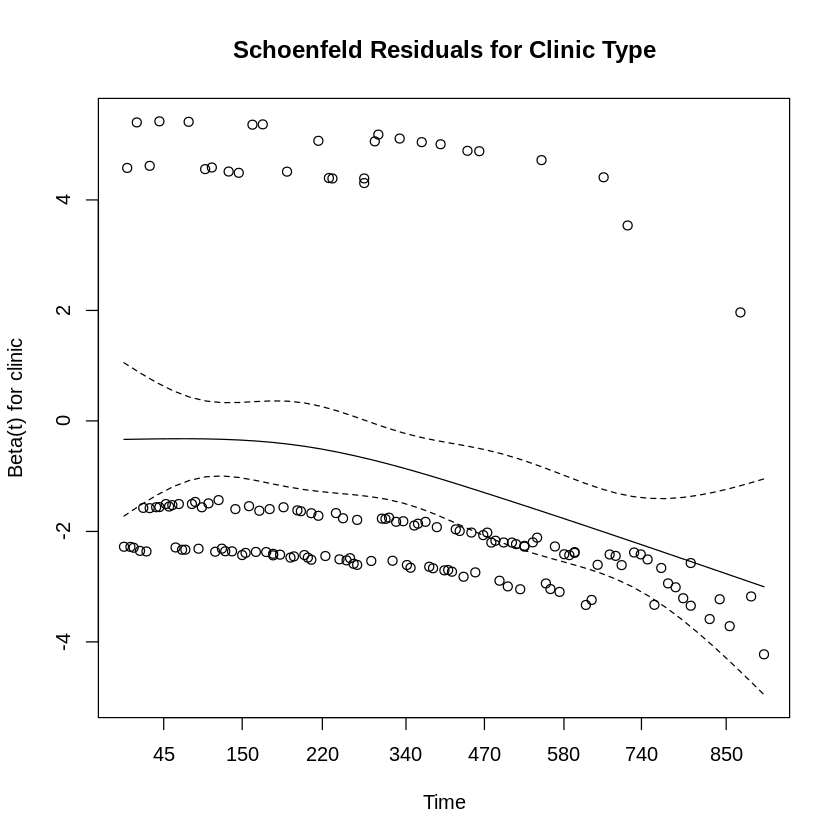

In [8]:
addicts.zph <- cox.zph(cox_model_1)
plot(addicts.zph[1], main = "Schoenfeld Residuals for Clinic Type")


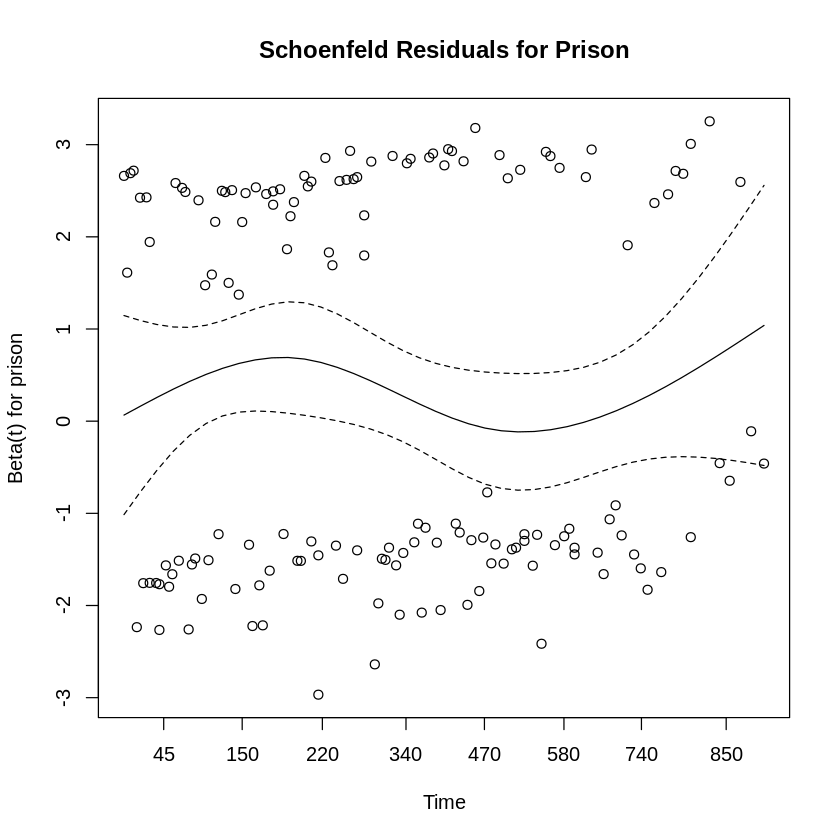

In [9]:
plot(addicts.zph[2], main = "Schoenfeld Residuals for Prison")

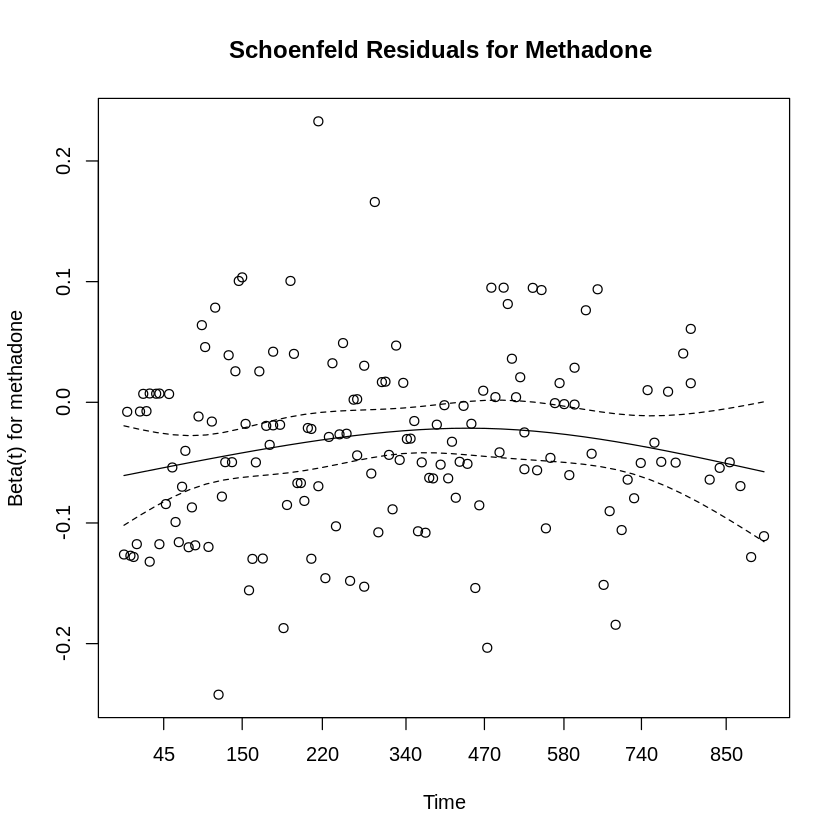

In [10]:
plot(addicts.zph[3], main = "Schoenfeld Residuals for Methadone ")

From the plots, we can see some reasonable patterns in the Schoenfield residuals of Clinic type and Methadone. 

#### **Interpretation**

### **Q 2**

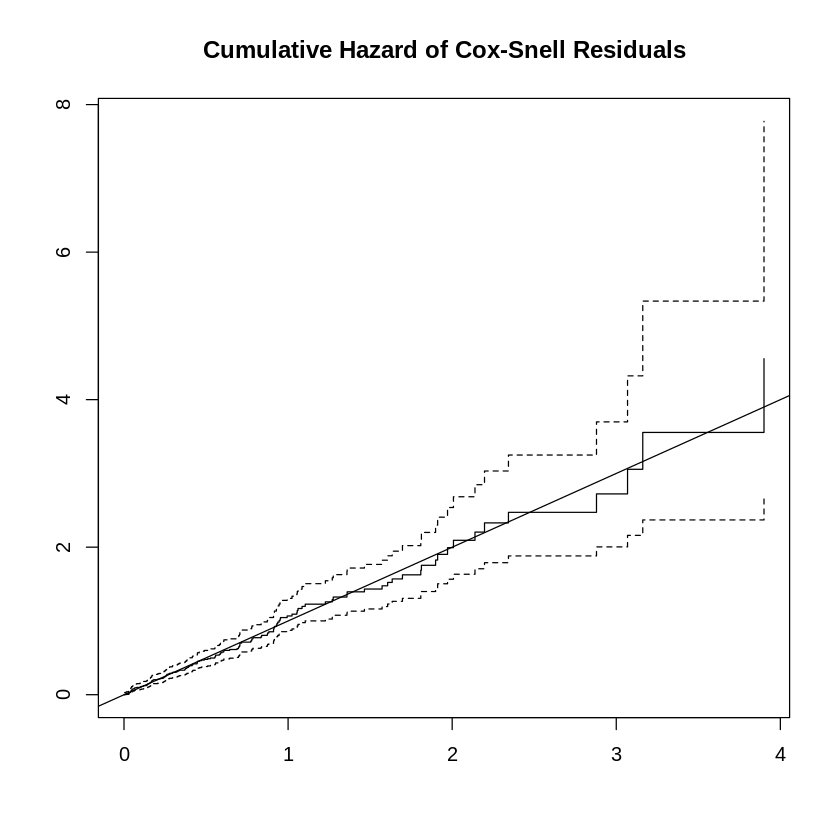

In [11]:
#fit martingale for full model
addicts.mart <- residuals(cox_model_1, type="martingale")
#find cox-snell residuals
addicts.cs <- addicts$status - addicts.mart
#cumaltive hazard of CS residuals
surv.csr <- survfit(Surv(addicts.cs,addicts$status)~1,type="fleming-harrington")

plot(surv.csr,fun="cumhaz")
abline(0,1)
title("Cumulative Hazard of Cox-Snell Residuals")

From the plot, we see the line has approximately a slop of 1 and an intercept of 0 (i.e it passes through the origin). We don't see a lack of fit based on these residuals.

### **Q3**

Plot the martingale residuals (omitting methadone) vs. methodone. The original paper using these data treated dose as a categorical variable with categories < 60, 60–79, and 80+. Make a categorized methadone variable using cut. Try fitting the model using categorized dose as a factor and compare to dose in statistical significance of the variable using the LR test (maybe with drop1) . Compare the two full models by AIC. Does it make an important difference to replace the quantitative variable by a 3-category factor? Note that you cannot compare the two models directly by a LR test since they are not nested.


Call:
coxph(formula = survival ~ clinic + prison, data = addicts)

  n= 238, number of events= 150 

             coef exp(coef) se(coef)      z Pr(>|z|)    
clinic 2  -1.1089    0.3299   0.2144 -5.173  2.3e-07 ***
prisonYes  0.2778    1.3203   0.1656  1.678   0.0933 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

          exp(coef) exp(-coef) lower .95 upper .95
clinic 2     0.3299     3.0309    0.2168    0.5022
prisonYes    1.3203     0.7574    0.9544    1.8263

Concordance= 0.599  (se = 0.025 )
Likelihood ratio test= 33.78  on 2 df,   p=5e-08
Wald test            = 28.17  on 2 df,   p=8e-07
Score (logrank) test = 30.51  on 2 df,   p=2e-07



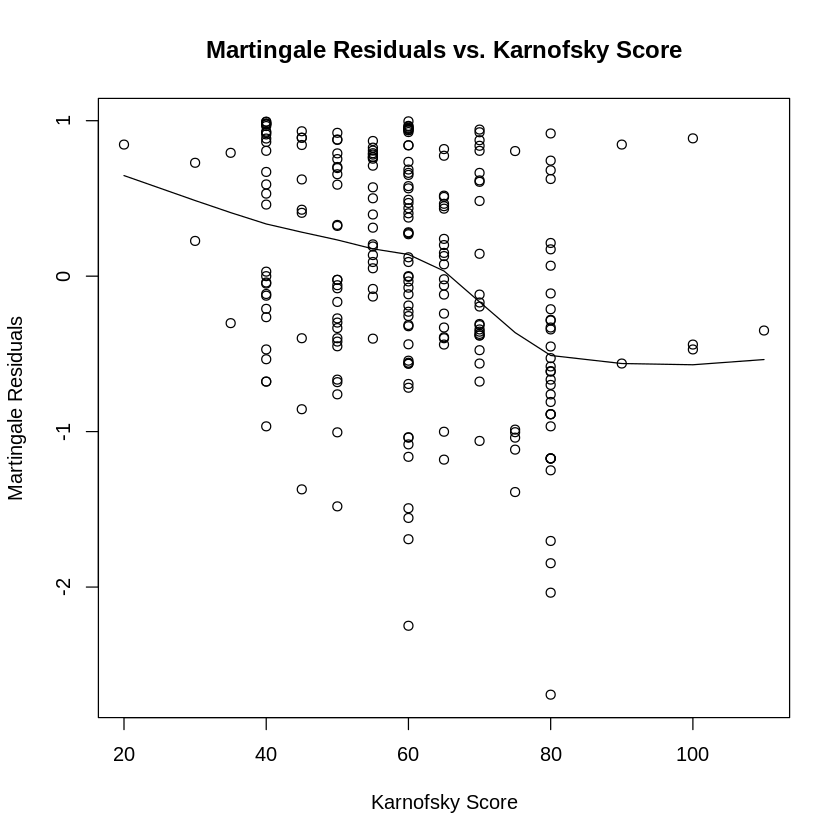

In [12]:
#fit without score
cox_model_2 <- coxph(survival~ clinic + prison, data = addicts)
print(summary(cox_model_2))
#find residuals
mres2 <- residuals(cox_model_2, type = "martingale")
#plot score vs residuals
plot(addicts$methadone,mres2,xlab="Karnofsky Score",ylab="Martingale Residuals")
lines(lowess(addicts$methadone,mres2))
title("Martingale Residuals vs. Karnofsky Score")

In [13]:
methadone_cat <- cut(addicts$methadone,c(0,60,80,max(addicts$methadone)+1),labels=c("Low","Medium", "High"))
table(methadone_cat)


methadone_cat
   Low Medium   High 
   145     87      6 

In [14]:

cox_model_3 <- coxph(survival~ clinic + prison + methadone_cat, data = addicts)
print(summary(cox_model_3))


Call:
coxph(formula = survival ~ clinic + prison + methadone_cat, data = addicts)

  n= 238, number of events= 150 

                       coef exp(coef) se(coef)      z Pr(>|z|)    
clinic 2            -0.9857    0.3732   0.2228 -4.424 9.71e-06 ***
prisonYes            0.2733    1.3143   0.1667  1.640    0.101    
methadone_catMedium -0.7354    0.4793   0.1810 -4.064 4.82e-05 ***
methadone_catHigh   -0.4418    0.6429   0.7425 -0.595    0.552    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                    exp(coef) exp(-coef) lower .95 upper .95
clinic 2               0.3732     2.6798    0.2411    0.5775
prisonYes              1.3143     0.7608    0.9480    1.8223
methadone_catMedium    0.4793     2.0863    0.3362    0.6834
methadone_catHigh      0.6429     1.5555    0.1500    2.7552

Concordance= 0.643  (se = 0.024 )
Likelihood ratio test= 51.51  on 4 df,   p=2e-10
Wald test            = 44.6  on 4 df,   p=5e-09
Score (logrank) test = 48.18  on 4 df,   p=

In [15]:
print(drop1(cox_model_1,test="Chisq"))

Single term deletions

Model:
survival ~ clinic + prison + methadone
          Df    AIC     LRT  Pr(>Chi)    
<none>       1352.5                      
clinic     1 1376.9 26.3506 2.847e-07 ***
prison     1 1354.3  3.7727   0.05209 .  
methadone  1 1381.3 30.7820 2.887e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [16]:
print(drop1(cox_model_2,test="Chisq"))

Single term deletions

Model:
survival ~ clinic + prison
       Df    AIC    LRT  Pr(>Chi)    
<none>    1381.3                     
clinic  1 1411.8 32.533 1.172e-08 ***
prison  1 1382.1  2.789   0.09493 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [17]:
print(drop1(cox_model_3,test="Chisq"))

Single term deletions

Model:
survival ~ clinic + prison + methadone_cat
              Df    AIC     LRT Pr(>Chi)    
<none>           1367.6                     
clinic         1 1389.0 23.3799 1.33e-06 ***
prison         1 1368.2  2.6641 0.102638    
methadone_cat  2 1381.3 17.7331 0.000141 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Looking at the AIC scores and the p-values, it does not appear that replacing the quantitative variable methadone with the 3-category factor gives an improvement. The p-value is not also better that that of the quantitative methadone.

### **Q 4**

In [18]:
#fit residuals
addicts.mart <- residuals(cox_model_3, type="martingale")
addicts.dev <- residuals(cox_model_3, type="deviance")
addicts.dfb <- residuals(cox_model_3, type="dfbeta")
#find linear predictor
addicts.preds <- predict(cox_model_3)

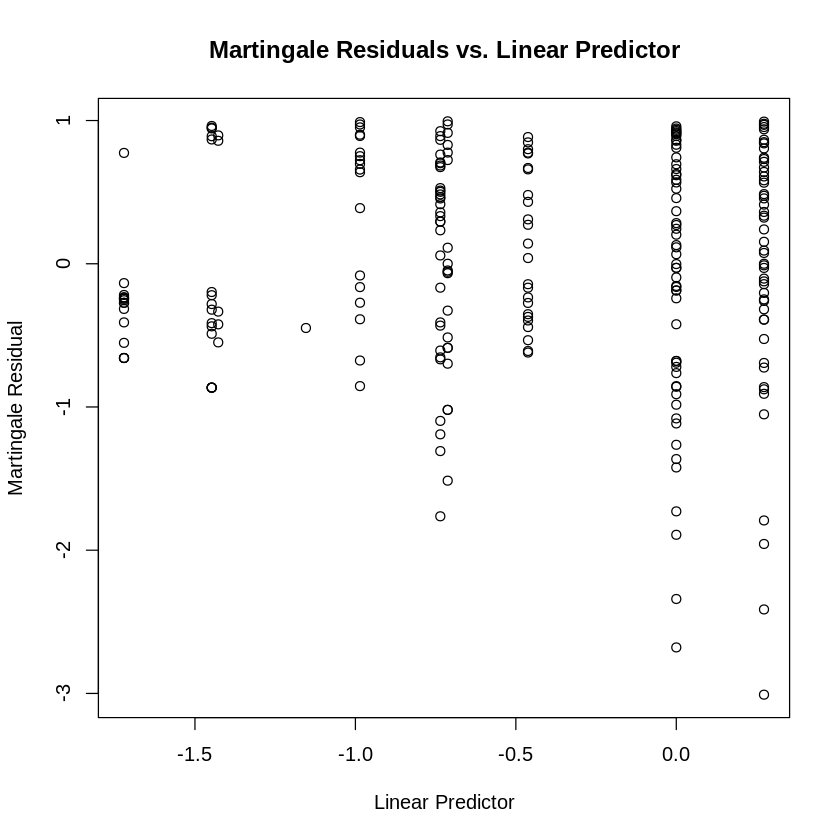

In [19]:
plot(addicts.preds,addicts.mart,xlab="Linear Predictor",ylab="Martingale Residual")
title("Martingale Residuals vs. Linear Predictor")

In [29]:
mart_df = data.frame(id = 1:length(addicts.mart), mart = addicts.mart)
mart_df <- mart_df[order(mart_df$mart),]

head(mart_df,3)
tail(mart_df,3)

,id,mart
,<int>,<dbl>
8,8,-3.008747
54,54,-2.678892
12,12,-2.413637


,id,mart
,<int>,<dbl>
116,116,0.9892910
175,175,0.9925482
123,123,0.9944176


Based on the plot, observations 8, 12 and 54 lie at the bottom i.e smallest martigale residuals.

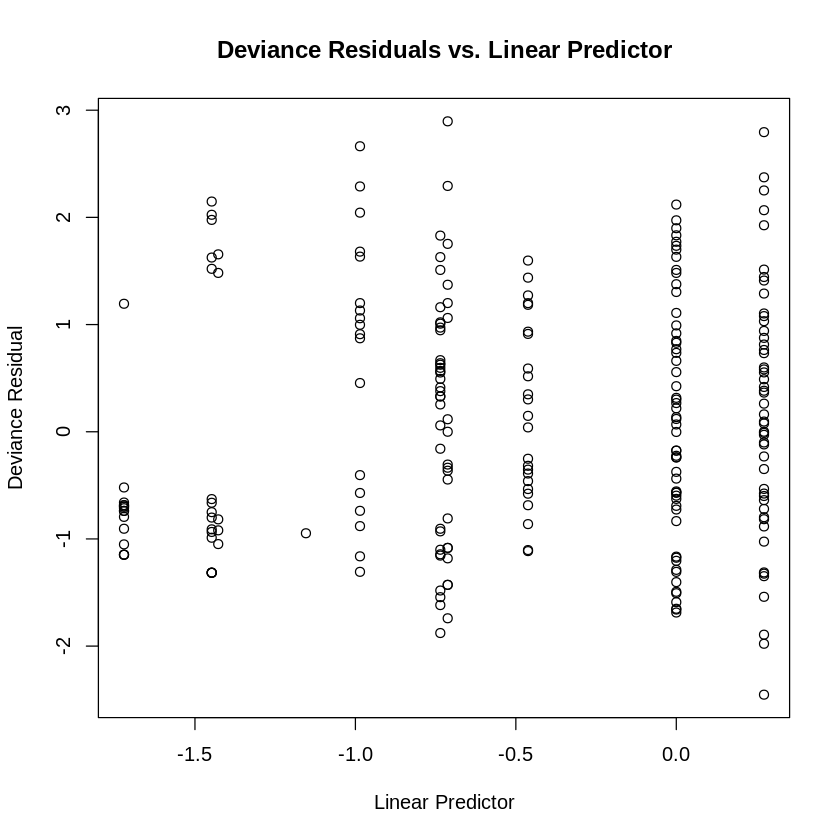

In [20]:
plot(addicts.preds,addicts.dev,xlab="Linear Predictor",ylab="Deviance Residual")
title("Deviance Residuals vs. Linear Predictor")

In [30]:
pred_df = data.frame(id = 1:length(addicts.preds), pred = addicts.preds)
pred_df <- pred_df[order(pred_df$pred),]
head(pred_df,3)
tail(pred_df,3)

,id,pred
,<int>,<dbl>
102,102,-1.721128
107,107,-1.721128
108,108,-1.721128


,id,pred
,<int>,<dbl>
228,228,0.2733304
233,233,0.2733304
234,234,0.2733304


Some of the smallest observations with respect to deviance residual are 102, 107, and 108. While the large observations are 228, 233, and 234.

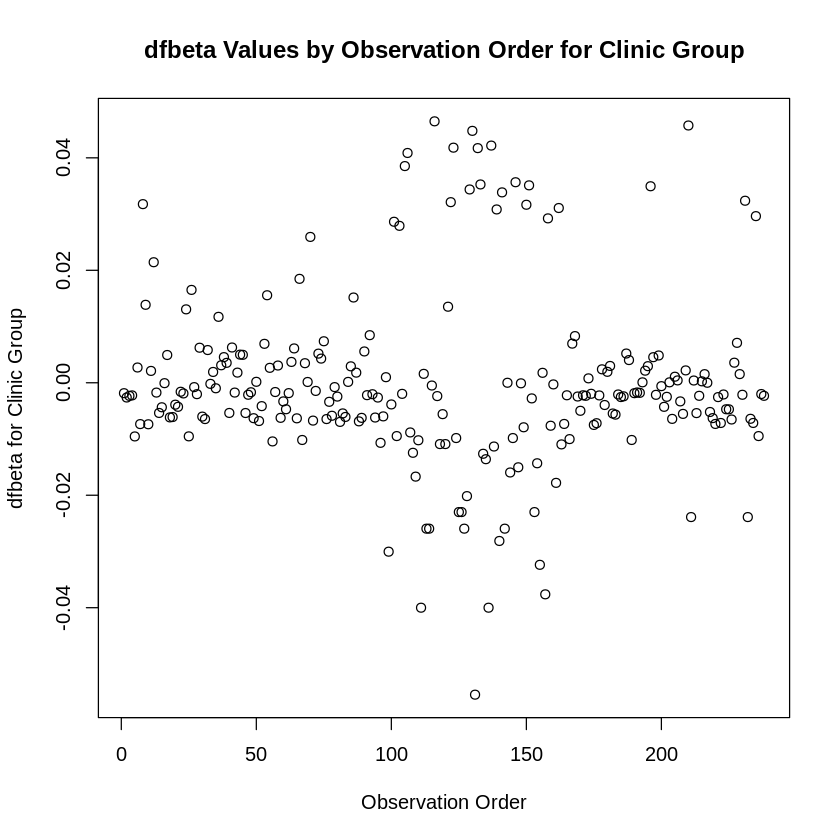

In [32]:
plot(addicts.dfb[,1],xlab="Observation Order",ylab="dfbeta for Clinic Group")
title("dfbeta Values by Observation Order for Clinic Group")

In [31]:
dfb1_df = data.frame(id = 1:length(addicts.dfb[,1]), dfb1 = addicts.dfb[,1])
dfb1_df <- dfb1_df[order(dfb1_df$dfb1),]

head(dfb1_df,3)
tail(dfb1_df,3)


,id,dfb1
,<int>,<dbl>
131,131,-0.05546883
111,111,-0.04000368
136,136,-0.04000368


,id,dfb1
,<int>,<dbl>
130,130,0.04479737
210,210,0.04575067
116,116,0.04649049


The three smallest bfbeta for clinic group are observations 111, 131, and 136, while the three largest are observation 116, 130, 210.

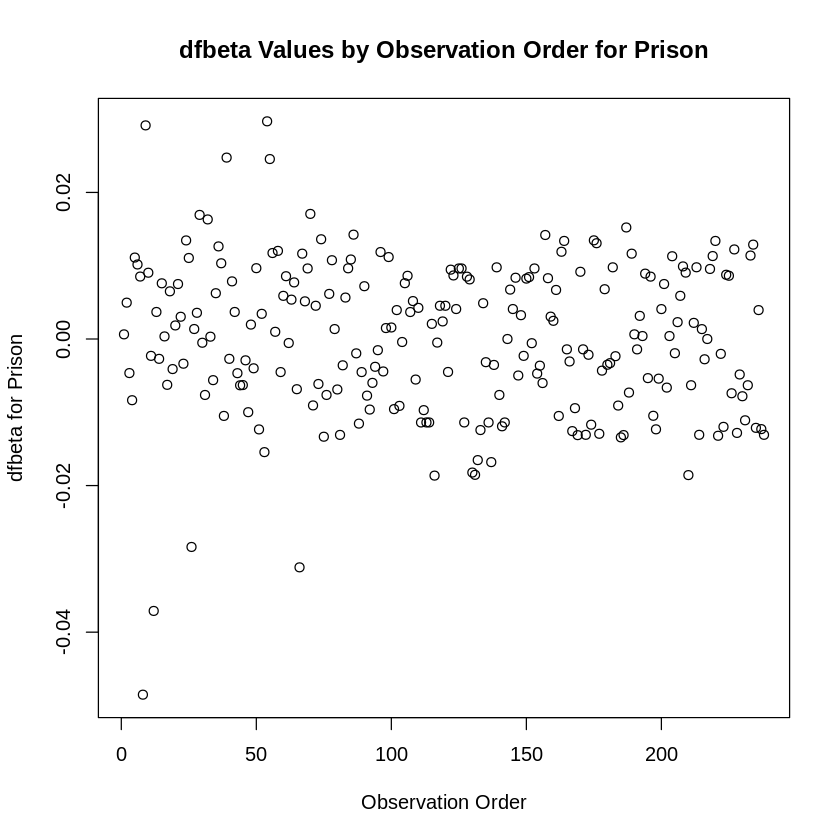

In [22]:
plot(addicts.dfb[,2],xlab="Observation Order",ylab="dfbeta for Prison")
title("dfbeta Values by Observation Order for Prison")

In [34]:
dfb2_df = data.frame(id = 1:length(addicts.dfb[,2]), dfb2 = addicts.dfb[,2])
dfb2_df <- dfb2_df[order(dfb2_df$dfb2),]

head(dfb2_df,4)
tail(dfb2_df,4)

,id,dfb2
,<int>,<dbl>
8,8,-0.04852518
12,12,-0.03710073
66,66,-0.03115319
26,26,-0.02837184


,id,dfb2
,<int>,<dbl>
55,55,0.02455145
39,39,0.02474983
9,9,0.02914404
54,54,0.02969710


The four smallest bfbeta for Prison are observations 8, 12, 26 and 66, while the three largest are observation 9, 39, 54, and 55.

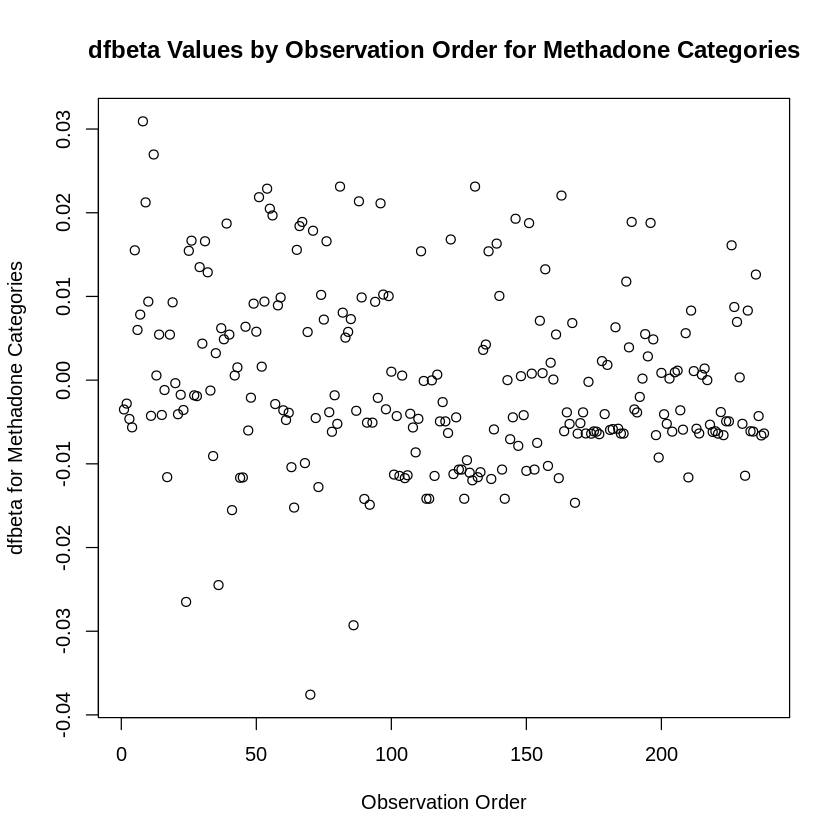

In [23]:
plot(addicts.dfb[,3],xlab="Observation Order",ylab="dfbeta for Methadone Categories")
title("dfbeta Values by Observation Order for Methadone Categories")

In [36]:
dfb3_df = data.frame(id = 1:length(addicts.dfb[,3]), dfb3 = addicts.dfb[,3])
dfb3_df <- dfb3_df[order(dfb3_df$dfb3),]

head(dfb3_df,4)
tail(dfb3_df,3)


,id,dfb3
,<int>,<dbl>
70,70,-0.03758068
86,86,-0.02928566
24,24,-0.02649934
36,36,-0.02448570


,id,dfb3
,<int>,<dbl>
131,131,0.02312599
12,12,0.02696051
8,8,0.03092226


The four smallest bfbeta for Methadone Categories group are observations 24, 36, 70, and 86, while the three largest are observation 8, 12, 131.

Martingale Residuals - 8, 12 and 54 

Deviance. Residuals - 102, 107, 108,228, 233, and 234.

Clinic Group Influence - 111, 131, 136, 116, 130, and 210.

Prison - 8, 12, 26 66, 9, 39, 54, and 55

Methadone Categorical - 24, 36, 70, 86, 8, 12, 131.

The most intresting observations seems to be 8, 12, 54, 131.

In [37]:
system("pip install pypandoc")

In [39]:

system("jupyter nbconvert --to HTML /content/BST_222_HW_4.ipynb")